In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

import os
print(os.listdir("../input"))

['chest-xray-pneumonia']


In [26]:
# keras libraries
from tensorflow import keras
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.applications.inception_v3 import InceptionV3

from keras.models import Model, Sequential
from keras.layers import Input, Lambda, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.metrics import classification_report, confusion_matrix

In [27]:
train_dir = '../input/chest-xray-pneumonia/chest_xray/train/'
test_dir = '../input/chest-xray-pneumonia/chest_xray/test/'
val_dir = '../input/chest-xray-pneumonia/chest_xray/val/'

In [28]:
train_normal = train_dir + 'NORMAL/'
train_pneumonia = train_dir + 'PNEUMONIA/'

In [29]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

## Let's look at some pictures

Text(0.5, 1.0, 'Pneumonia')

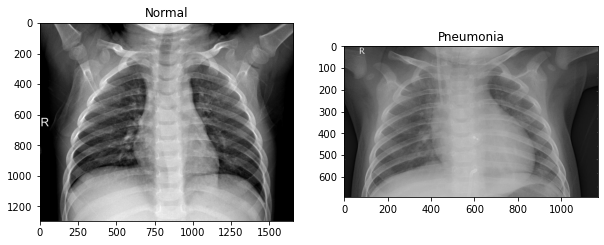

In [30]:
# normal pic
rand_norm = np.random.randint(0, len(os.listdir(train_normal)))
normal_pic = os.listdir(train_normal)[rand_norm]
normal_pic_address = train_normal+normal_pic

# pneumonia pic
rand_norm = np.random.randint(0, len(os.listdir(train_pneumonia)))
pneumonia_pic = os.listdir(train_pneumonia)[rand_norm]
pneumonia_pic_address = train_pneumonia+pneumonia_pic

# load the images
normal_load = Image.open(normal_pic_address)
pneumonia_load = Image.open(pneumonia_pic_address)

# plot
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(normal_load, cmap='gray')
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(pneumonia_load, cmap='gray')
a2.set_title('Pneumonia')

## Vgg16 Model

In [31]:
# base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=[150,150,3])

# for layer in base_model.layers:
#     layer.trainable = False

In [32]:
vgg = VGG16(input_shape=[150, 150, 3], weights='imagenet', include_top=False)

for layer in vgg.layers:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [33]:
# x = base_model.output
# x = Dropout(0.5)(x)
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu')(x)
# x = BatchNormalization()(x)
# predictions = Dense(2, activation='sigmoid')(x)

# model = Model(inputs=base_model.input, outputs=predictions)

In [34]:
flatten1 = Flatten()(vgg.output)
dense1 = Dense(256, activation="relu")(flatten1)
dropout1 = Dropout(0.5)(dense1)
prediction = Dense(2, activation="softmax")(dropout1)

model = Model(inputs=vgg.input, outputs=prediction)

In [35]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0   

In [36]:
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [37]:
# loading the images
train_datagen = ImageDataGenerator(rescale=1./255,
                            rotation_range=30,
                            zoom_range=0.15,
                            horizontal_flip=True,
                            fill_mode="nearest")


test_datagen = ImageDataGenerator(rescale=1./255)

training_set = train_datagen.flow_from_directory(train_dir,
                                    target_size=(150, 150),
                                    color_mode='rgb',
                                    batch_size=32,
                                    class_mode='categorical',
                                    shuffle=True)

validation_set = test_datagen.flow_from_directory(val_dir,
                                    target_size=(150, 150),
                                    color_mode='rgb',
                                    batch_size=32,
                                    class_mode='categorical',
                                    shuffle=True)

test_set = test_datagen.flow_from_directory(test_dir,
                                    target_size=(150, 150),
                                    color_mode='rgb',
                                    batch_size = 32,
                                    class_mode='categorical')

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [88]:
early_stop = EarlyStopping(monitor='val_loss',patience=3)

history = model.fit_generator(training_set,
                               steps_per_epoch=128,
                               epochs=6,
                               validation_data=validation_set,
                               validation_steps=len(validation_set))

Epoch 1/6
128/128 [==============================] - 61s 477ms/step - loss: 0.1232 - accuracy: 0.9539 - val_loss: 0.3712 - val_accuracy: 0.7500
Epoch 2/6
128/128 [==============================] - 62s 487ms/step - loss: 0.1335 - accuracy: 0.9490 - val_loss: 0.3021 - val_accuracy: 0.7500
Epoch 3/6
128/128 [==============================] - 63s 489ms/step - loss: 0.1126 - accuracy: 0.9585 - val_loss: 0.2305 - val_accuracy: 0.8750
Epoch 4/6
128/128 [==============================] - 61s 480ms/step - loss: 0.1084 - accuracy: 0.9592 - val_loss: 0.2028 - val_accuracy: 0.9375
Epoch 5/6
128/128 [==============================] - 63s 490ms/step - loss: 0.1024 - accuracy: 0.9585 - val_loss: 0.2806 - val_accuracy: 0.8125
Epoch 6/6
128/128 [==============================] - 63s 490ms/step - loss: 0.1222 - accuracy: 0.9568 - val_loss: 0.2212 - val_accuracy: 0.8750


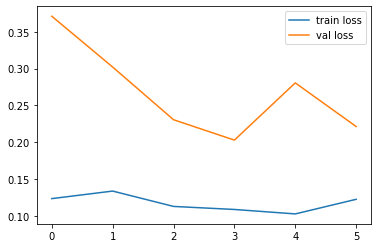

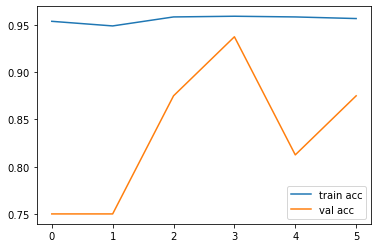

<Figure size 432x288 with 0 Axes>

In [89]:
# plot the loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

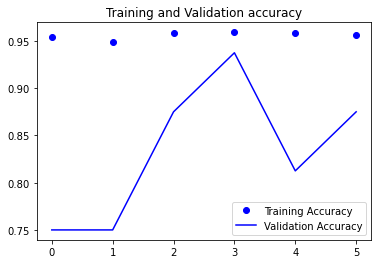

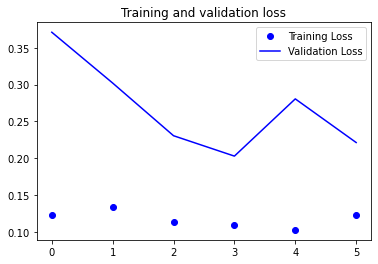

In [90]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'bo', label='Training Accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation Accuracy')
plt.title('Training and Validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [91]:
model.save('pneumonia_model.h5')

In [99]:
img=image.load_img('../input/chest-xray-pneumonia/chest_xray/test/NORMAL/IM-0005-0001.jpeg',
                   target_size=(150,150))

In [100]:
x=image.img_to_array(img)
x

array([[[ 45.,  45.,  45.],
        [ 42.,  42.,  42.],
        [135., 135., 135.],
        ...,
        [ 30.,  30.,  30.],
        [ 43.,  43.,  43.],
        [ 58.,  58.,  58.]],

       [[169., 169., 169.],
        [175., 175., 175.],
        [180., 180., 180.],
        ...,
        [ 90.,  90.,  90.],
        [ 44.,  44.,  44.],
        [ 27.,  27.,  27.]],

       [[176., 176., 176.],
        [174., 174., 174.],
        [172., 172., 172.],
        ...,
        [129., 129., 129.],
        [ 45.,  45.,  45.],
        [ 31.,  31.,  31.]],

       ...,

       [[ 59.,  59.,  59.],
        [ 32.,  32.,  32.],
        [ 19.,  19.,  19.],
        ...,
        [ 13.,  13.,  13.],
        [ 10.,  10.,  10.],
        [ 30.,  30.,  30.]],

       [[ 64.,  64.,  64.],
        [ 32.,  32.,  32.],
        [ 19.,  19.,  19.],
        ...,
        [ 11.,  11.,  11.],
        [ 10.,  10.,  10.],
        [ 21.,  21.,  21.]],

       [[ 63.,  63.,  63.],
        [ 33.,  33.,  33.],
        [ 19.,  

In [101]:
x.shape

(150, 150, 3)

In [102]:
x=x/255

In [103]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 150, 150, 3)

In [104]:
pred = np.argmax(model.predict(img_data), axis=1)
pred

array([1])

In [105]:
if(pred==1):
    print("Uninfected")
else:
    print("Infected")

Uninfected
